In [2]:
import pandas as pd
from collections import defaultdict

dge_file = "./rnaseq/results/deseq2/deseq2_results.csv"
gff_file = "./rnaseq/resources/Genome/genomic.gff"
interpro_file = "./rnaseq/results/interproscan_output.tsv"
output_file = "./rnaseq/results/dge_annotated.csv"

gene_to_protein = {}

with open(gff_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        cols = line.strip().split('\t')
        if len(cols) < 9:
            continue
        feature = cols[2]
        attr = {kv.split('=')[0]: kv.split('=')[1] for kv in cols[8].split(';') if '=' in kv}
        if feature == "CDS":
            parent = attr.get('Parent', '').replace('gene-', '')
            protein_id = attr.get('protein_id')
            if parent and protein_id:
                gene_to_protein[parent] = protein_id

protein_to_go = defaultdict(set)

with open(interpro_file, 'r') as f:
    for line in f:
        cols = line.strip().split('\t')
        if len(cols) < 14 or not cols[13]:
            continue
        protein_id = cols[0]
        go_terms = cols[13].split('|')
        for go in go_terms:
            protein_to_go[protein_id].add(go)

dge = pd.read_csv(dge_file)

dge['gene_clean'] = dge['gene'].str.replace(r'^KPHS_t', 'KPHS_', regex=True)

dge['protein_id'] = dge['gene_clean'].map(gene_to_protein)

dge['GO_terms'] = dge['protein_id'].map(lambda pid: ';'.join(protein_to_go[pid]) if pid in protein_to_go else None)


✅ Annotated DGE file saved to: ./rnaseq/results/dge_annotated.csv


In [7]:
from goatools.obo_parser import GODag

go_file = "./rnaseq/results/go-basic.obo.obo"
go_dag = GODag(go_file)

def describe_go_term(go_id):
    try:
        return go_dag[go_id].name
    except:
        return "unknown"

def map_go_terms(term_string):
    if pd.isna(term_string) or term_string == "None":
        return "-"
    terms = [go.split('(')[0] for go in term_string.split(';') if go and go != '-']
    return ';'.join([describe_go_term(go) for go in terms])

dge['GO_descriptions'] = dge['GO_terms'].apply(map_go_terms)


./rnaseq/results/go-basic.obo.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms


In [17]:
dge['significant'] = dge['padj'] < 0.05

In [18]:
cols_to_save = ['gene', 'log2FoldChange', 'padj', 'protein_id', 'GO_terms', 'GO_descriptions', 'significant']
dge[cols_to_save].to_csv(output_file, index=False)

print(f"\n✅ Annotated DGE file saved to: {output_file}")


✅ Annotated DGE file saved to: ./rnaseq/results/dge_annotated.csv


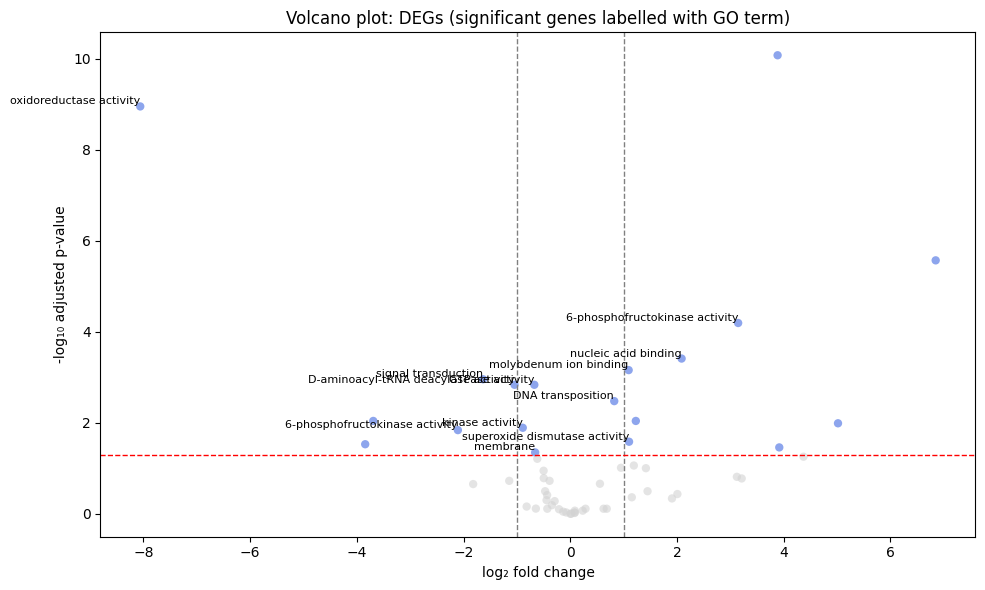

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

dge['significant'] = dge['padj'] < 0.05
dge['has_GO'] = dge['GO_descriptions'].apply(lambda x: x != "-" and pd.notna(x))

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=dge,
    x="log2FoldChange",
    y=-np.log10(dge["padj"]),
    hue="significant",
    palette={True: "royalblue", False: "lightgrey"},
    edgecolor=None,
    alpha=0.6,
    linewidth=0,
    legend=False
)

plt.axvline( 1, linestyle='--', color='grey', linewidth=1)
plt.axvline(-1, linestyle='--', color='grey', linewidth=1)

plt.axhline(-np.log10(0.05), linestyle='--', color='red', linewidth=1)

sig = dge[dge['significant'] & dge['has_GO']]
for _, row in sig.iterrows():
    label = row['GO_descriptions'].split(';')[0]          # first GO desc
    plt.text(row['log2FoldChange'],
             -np.log10(row['padj']),
             label,
             fontsize=8,
             ha='right', va='bottom', color='black')

plt.xlabel("log₂ fold change")
plt.ylabel("-log₁₀ adjusted p-value")
plt.title("Volcano plot: DEGs (significant genes labelled with GO term)")
plt.tight_layout()

plt.savefig("./rnaseq/results/annotated_volcano_with_thresholds.png", dpi=330)
plt.show()